
# Monitor data processing



## Load  libraries

In [1]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path

# system paths
import sys
home = str(Path.home())
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'
from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

# manipulation libraries
import pandas as pd
import datetime
from siuba import *

# visualization
import plotnine as p9
p9.theme_set(p9.theme_linedraw()) # default theme

# aws connection
import boto3
import awswrangler as wr

# local libraries
from src import utils

In [2]:
conn = utils.connect_athena(path='../configs/athena.yaml')

## Private observed


### daily

In [3]:
#df_daily = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/dev/public/daily/write_index/daily.csv", sep = ",")


In [4]:
qry = """select last_updated_utc, region_slug, region_name, country_name, 
        country_iso_code, country_idb_code, region_type, population, 
        timezone, year, month, day, dow, 
        observed, expected_2020,
        ratio_20, tcp, dashboard,
        date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
    from spd_sdv_waze_corona.dev_daily_daily_index"""
df_daily = pd.read_sql_query(qry, conn)

In [5]:
print(df_daily.shape)
# (52264, 18)
# (66490, 18)
# (67826, 18)
# (68688, 18)
# (70200, 19)
# (72360, 19)
df_daily.head()

(76464, 19)


,last_updated_utc,region_slug,region_name,country_name,country_iso_code,country_idb_code,region_type,population,timezone,year,month,day,dow,observed,expected_2020,ratio_20,tcp,dashboard,date
0,2022-02-16 23:07:56.038,monterrey,Monterrey,Mexico,MX,ME,city,4374265,America/Monterrey,2021,3,21,7,13863259,15310215.5,0.905491,-9.450922,TRUE,2021-03-21
1,2022-02-16 23:07:56.038,monterrey,Monterrey,Mexico,MX,ME,city,4374265,America/Monterrey,2020,7,12,7,7775003,15310215.5,0.507831,-49.216894,TRUE,2020-07-12
2,2022-02-16 23:07:56.038,monterrey,Monterrey,Mexico,MX,ME,city,4374265,America/Monterrey,2020,8,16,7,9135501,15310215.5,0.596693,-40.330683,TRUE,2020-08-16
3,2022-02-16 23:07:56.038,monterrey,Monterrey,Mexico,MX,ME,city,4374265,America/Monterrey,2021,5,16,7,13520884,15310215.5,0.883128,-11.687174,TRUE,2021-05-16
4,2022-02-16 23:07:56.038,monterrey,Monterrey,Mexico,MX,ME,city,4374265,America/Monterrey,2020,9,6,7,10324874,15310215.5,0.674378,-32.562190,TRUE,2020-09-06


In [6]:
(df_daily[(df_daily.date >= '2021-11-01') & (df_daily.date < '2022-11-30')]
 >> group_by('date')
 >> summarize(regions = _.region_slug.nunique())
 >> arrange('date')
 >> group_by('regions')
 >> summarize(n = _.date.nunique())
)

,regions,n
0,108,107


In [7]:
(df_daily 
 >> filter(_.dashboard == 'TRUE')
 >> group_by('region_slug')
 >> summarize(n_count = _.last_updated_utc.count())
 >> arrange('n_count')
 >> group_by('n_count')
 >> summarize(n = _.region_slug.count())
)


,n_count,n
0,708,78


In [8]:
#(df_daily 
# >> filter(_.dashboard == 'TRUE')
# >> group_by('region_slug')
# >> summarize(n_count = _.last_updated_utc.count(),
#             min_date = _.date.min(), 
#             max_date = _.date.max())
# >> arrange('n_count')
#)

In [9]:
(df_daily 
 >> group_by('dashboard')
 >> summarize(n_count = _.region_slug.nunique())
) # 30 - 78

,dashboard,n_count
0,FALSE,30
1,TRUE,78


In [10]:
if False:
    print(df_daily
     >> filter(_.tcp > 200, _.dashboard == 'TRUE')
     >> group_by('dashboard', 'region_slug')
     >> summarize(n_count = _.region_slug.nunique())
    )

/home/soniame/.conda/envs/waze_coronavirus/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


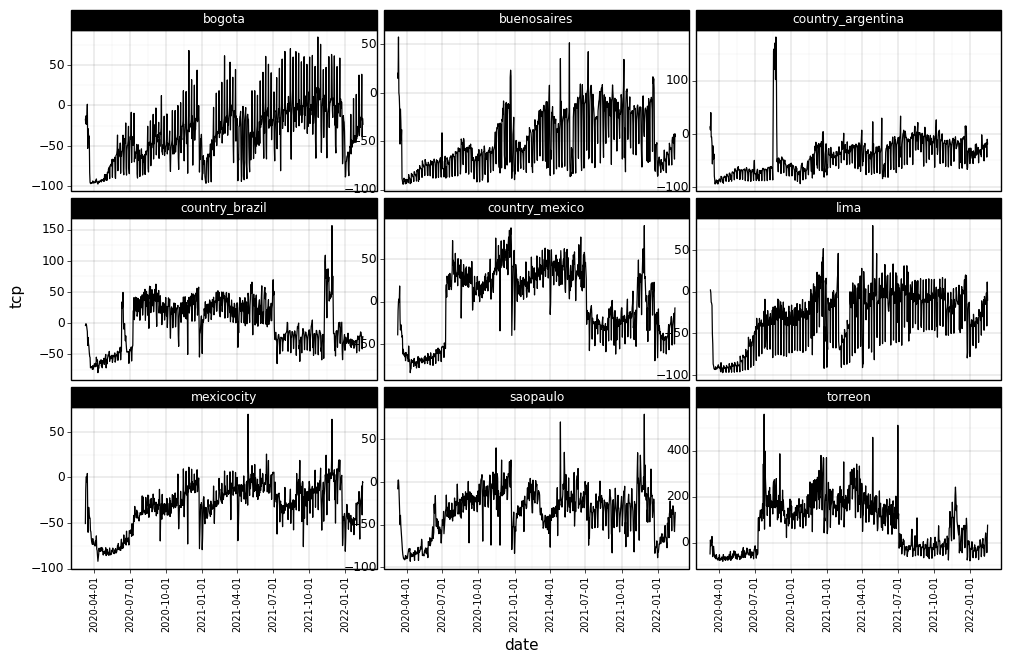

<ggplot: (8729346877601)>


In [11]:
if True: 
    #df_pl = df_daily.loc[(df_daily.region_slug.isin(['lima'])) & (df_daily.month == 7) & (df_daily.year == 2021)]
    df_pl = df_daily.loc[(df_daily.region_slug.isin(['country_mexico', 'country_brazil', 
                                                     'mexicocity', 'lima', 'torreon',
                                                    'saopaulo', 'buenosaires', 'country_argentina', 
                                                    'bogota']))]
    print(p9.ggplot(df_pl, p9.aes(x = 'date', y='tcp', group = 'region_slug')) 
     + p9.geom_line() 
     + p9.facet_wrap('region_slug', scales='free_y')
     #+ p9.geom_point()
     + p9.theme(figure_size=(12, 7),
                axis_text_x=p9.element_text(size = 7, angle = 90)) )

In [12]:
df_daily.date.max()

Timestamp('2022-02-15 00:00:00')

In [13]:
if True:
    # Remove countries columns
    df_daily.loc[df_daily.region_slug.isin(['country_brazil', 'country_mexico']), 'tcp'] = None
    df_daily.loc[df_daily.region_slug.isin(['country_brazil', 'country_mexico']), 'dashboard'] = 'FALSE'
    # Remove date column
    df_daily = df_daily.drop(columns=['date'])
df_daily.head(3)    

,last_updated_utc,region_slug,region_name,country_name,country_iso_code,country_idb_code,region_type,population,timezone,year,month,day,dow,observed,expected_2020,ratio_20,tcp,dashboard
0,2022-02-16 23:07:56.038,monterrey,Monterrey,Mexico,MX,ME,city,4374265,America/Monterrey,2021,3,21,7,13863259,15310215.5,0.905491,-9.450922,TRUE
1,2022-02-16 23:07:56.038,monterrey,Monterrey,Mexico,MX,ME,city,4374265,America/Monterrey,2020,7,12,7,7775003,15310215.5,0.507831,-49.216894,TRUE
2,2022-02-16 23:07:56.038,monterrey,Monterrey,Mexico,MX,ME,city,4374265,America/Monterrey,2020,8,16,7,9135501,15310215.5,0.596693,-40.330683,TRUE


In [14]:
# Write
if True:
    df_daily.to_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/dev/private/daily/write_index/daily_pr.csv", index=False)

### weekly

In [15]:
qry = """select *
from spd_sdv_waze_corona.dev_daily_weekly_index """
df = pd.read_sql_query(qry, conn)

In [16]:
df.loc[df.region_slug.isin(['country_brazil', 'country_mexico']), 'dashboard'] = 'FALSE'

In [17]:
qry = """select last_updated_utc, region_slug, region_name, country_name, 
	country_iso_code, country_idb_code, region_type, population, 
	timezone,  week_number, week_number_obs, 
    min_year, min_month, min_day, max_month, max_day, 
    observed, expected_2020,
	ratio_20, tcp, dashboard,
    date_parse(concat(cast(min_year as varchar), ' ', cast(min_month as varchar), ' ', cast(min_day as varchar)), '%Y %m %e') date
from spd_sdv_waze_corona.dev_daily_weekly_index """
df_weekly = pd.read_sql_query(qry, conn)

In [18]:
print(df_weekly.shape)
# (8085, 21)
# (10516, 21)
# (10633, 21)
# (10867, 21)
# (11218, 21)
#df_weekly.head()

(11920, 22)


In [19]:
df_weekly.date.max()

Timestamp('2022-02-14 00:00:00')

In [20]:
regions_daily = df_daily[df_daily.dashboard == 'TRUE'].region_slug.unique().tolist()
df_weekly.loc[df_weekly.region_slug.isin(regions_daily) == False, 'dashboard'] = 'FALSE'
print(df_weekly.shape)

(11920, 22)


In [21]:
(df_weekly 
 >> filter(_.dashboard == 'TRUE')
 >> group_by('region_slug')
 >> summarize(n_count = _.last_updated_utc.count())
 >> arrange('n_count')
 >> group_by('n_count')
 >> summarize(n = _.region_slug.count())
)

,n_count,n
0,102,76


In [22]:
(df_weekly 
 >> group_by('dashboard')
 >> summarize(n_count = _.region_slug.nunique())
)

,dashboard,n_count
0,FALSE,41
1,TRUE,76


In [23]:
if True:
    print(df_weekly
     >> filter(_.tcp > 200, _.dashboard == 'TRUE')
     >> group_by('dashboard', 'region_slug')
     >> summarize(n_count = _.region_slug.nunique())
    )

  dashboard region_slug  n_count
0      TRUE     torreon        1


/home/soniame/.conda/envs/waze_coronavirus/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


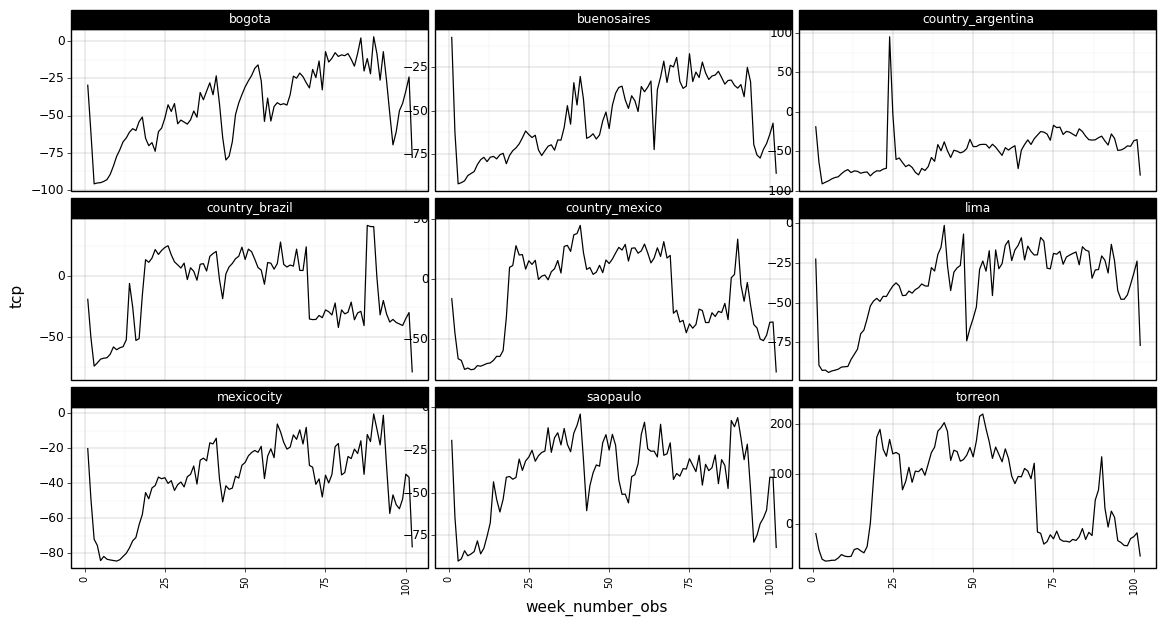

<ggplot: (8729347993157)>


In [24]:
if True: 
    df_pl = df_weekly.loc[df_weekly.region_slug.isin(['country_mexico', 'country_brazil', 
                                                     'mexicocity', 'lima', 'torreon',
                                                    'saopaulo', 'buenosaires', 'country_argentina', 
                                                    'bogota'])]
    print(p9.ggplot(df_pl, p9.aes(x = 'week_number_obs', y='tcp', group = 'region_slug')) 
     + p9.geom_line() 
     + p9.facet_wrap('region_slug', scales='free_y')          
     + p9.theme(figure_size=(14, 7),
                axis_text_x=p9.element_text(size = 7, angle = 90)) )

In [25]:
if True:
    # Remove countries columns
    df_weekly.loc[df_weekly.region_slug.isin(['country_brazil', 'country_mexico']), 'tcp'] = None
    df_weekly.loc[df_weekly.region_slug.isin(['country_brazil', 'country_mexico']), 'dashboard'] = 'FALSE'
    # Remove date column
    df_weekly = df_weekly.drop(columns=['date'])
df_weekly.head(3)

,last_updated_utc,region_slug,region_name,country_name,country_iso_code,country_idb_code,region_type,population,timezone,week_number,...,min_year,min_month,min_day,max_month,max_day,observed,expected_2020,ratio_20,tcp,dashboard
0,2022-02-16 23:06:33.902,guatemala,Ciudad de Guatemala,Guatemala,GT,GU,city,3204668,America/Guatemala,1,...,2022,1,3,1,9,144496234,315011892,0.458701,-54.129911,TRUE
1,2022-02-16 23:06:33.902,guatemala,Ciudad de Guatemala,Guatemala,GT,GU,city,3204668,America/Guatemala,26,...,2021,6,28,7,4,204205417,315011892,0.648247,-35.175331,TRUE
2,2022-02-16 23:06:33.902,guatemala,Ciudad de Guatemala,Guatemala,GT,GU,city,3204668,America/Guatemala,24,...,2020,6,8,6,14,108262034,315011892,0.343676,-65.632398,TRUE


In [26]:
# Write
if True:
    df_weekly.to_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/dev/private/daily/write_index/weekly_pr.csv", index=False)
    

## Public observed

### daily

In [27]:
#df_daily = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/dev/private/daily/write_index/daily_pr.csv")
df_daily.head()

,last_updated_utc,region_slug,region_name,country_name,country_iso_code,country_idb_code,region_type,population,timezone,year,month,day,dow,observed,expected_2020,ratio_20,tcp,dashboard
0,2022-02-16 23:07:56.038,monterrey,Monterrey,Mexico,MX,ME,city,4374265,America/Monterrey,2021,3,21,7,13863259,15310215.5,0.905491,-9.450922,TRUE
1,2022-02-16 23:07:56.038,monterrey,Monterrey,Mexico,MX,ME,city,4374265,America/Monterrey,2020,7,12,7,7775003,15310215.5,0.507831,-49.216894,TRUE
2,2022-02-16 23:07:56.038,monterrey,Monterrey,Mexico,MX,ME,city,4374265,America/Monterrey,2020,8,16,7,9135501,15310215.5,0.596693,-40.330683,TRUE
3,2022-02-16 23:07:56.038,monterrey,Monterrey,Mexico,MX,ME,city,4374265,America/Monterrey,2021,5,16,7,13520884,15310215.5,0.883128,-11.687174,TRUE
4,2022-02-16 23:07:56.038,monterrey,Monterrey,Mexico,MX,ME,city,4374265,America/Monterrey,2020,9,6,7,10324874,15310215.5,0.674378,-32.562190,TRUE


In [28]:
df_daily = df_daily[df_daily.dashboard.isin([True, 'TRUE'])].drop(['observed', 'expected_2020', 'dashboard', 'ratio_20'], axis=1)
df_daily.shape

(53808, 14)

In [29]:
if True:
    df_daily.to_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/dev/public/daily/write_index/daily_pu.csv", index=False)

### weekly

In [30]:
#df_weekly = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/dev/private/daily/write_index/weekly_pr.csv")
df_weekly.head(3)

,last_updated_utc,region_slug,region_name,country_name,country_iso_code,country_idb_code,region_type,population,timezone,week_number,...,min_year,min_month,min_day,max_month,max_day,observed,expected_2020,ratio_20,tcp,dashboard
0,2022-02-16 23:06:33.902,guatemala,Ciudad de Guatemala,Guatemala,GT,GU,city,3204668,America/Guatemala,1,...,2022,1,3,1,9,144496234,315011892,0.458701,-54.129911,TRUE
1,2022-02-16 23:06:33.902,guatemala,Ciudad de Guatemala,Guatemala,GT,GU,city,3204668,America/Guatemala,26,...,2021,6,28,7,4,204205417,315011892,0.648247,-35.175331,TRUE
2,2022-02-16 23:06:33.902,guatemala,Ciudad de Guatemala,Guatemala,GT,GU,city,3204668,America/Guatemala,24,...,2020,6,8,6,14,108262034,315011892,0.343676,-65.632398,TRUE


In [31]:
df_weekly = df_weekly[df_weekly.dashboard.isin([True, 'TRUE'])].drop(['observed', 'expected_2020', 'dashboard', 'ratio_20'], axis=1)
df_weekly.shape

(7752, 17)

In [32]:
if True:
    df_weekly.to_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/dev/public/daily/write_index/weekly_pu.csv", index=False)

In [33]:
df_weekly[df_weekly.week_number == 90]

(df_weekly
 >> group_by('week_number_obs')
 >> summarize(day = _.min_day.min(), )
)

,week_number_obs,day
0,1,9
1,2,16
2,3,23
3,4,30
4,5,6
...,...,...
97,98,17
98,99,24
99,100,31
100,101,7
